###  MicroGrad demo

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [12]:
np.random.seed(1337)
random.seed(1337)

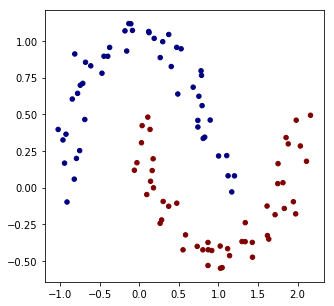

In [13]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [20]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [[0] Layer of [ReLUNeuron([(0, 0)]2), ReLUNeuron([(0, 1)]2), ReLUNeuron([(0, 2)]2), ReLUNeuron([(0, 3)]2), ReLUNeuron([(0, 4)]2), ReLUNeuron([(0, 5)]2), ReLUNeuron([(0, 6)]2), ReLUNeuron([(0, 7)]2), ReLUNeuron([(0, 8)]2), ReLUNeuron([(0, 9)]2), ReLUNeuron([(0, 10)]2), ReLUNeuron([(0, 11)]2), ReLUNeuron([(0, 12)]2), ReLUNeuron([(0, 13)]2), ReLUNeuron([(0, 14)]2), ReLUNeuron([(0, 15)]2)], [1] Layer of [ReLUNeuron([(1, 0)]16), ReLUNeuron([(1, 1)]16), ReLUNeuron([(1, 2)]16), ReLUNeuron([(1, 3)]16), ReLUNeuron([(1, 4)]16), ReLUNeuron([(1, 5)]16), ReLUNeuron([(1, 6)]16), ReLUNeuron([(1, 7)]16), ReLUNeuron([(1, 8)]16), ReLUNeuron([(1, 9)]16), ReLUNeuron([(1, 10)]16), ReLUNeuron([(1, 11)]16), ReLUNeuron([(1, 12)]16), ReLUNeuron([(1, 13)]16), ReLUNeuron([(1, 14)]16), ReLUNeuron([(1, 15)]16)], [2] Layer of [LinearNeuron([(2, 0)]16)]]
number of parameters 337


In [15]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [16]:
dl

Value(data=0.8862514464368222, grad=0)

In [18]:
from micrograd.nn import enable_sumv

# enable_sumv(True)
enable_sumv(False)

# optimization
for k in range(100):
    
    # forward
    total_loss, acc, reg_loss, data_loss = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%, rl {reg_loss.data}, dl {data_loss.data}")


step 0 loss 0.8958441028683222, accuracy 50.0%, rl 0.009592656431500009, dl 0.8862514464368222
step 1 loss 1.723590533697202, accuracy 81.0%, rl 0.010424424406302852, dl 1.7131661092908992
step 2 loss 0.742900631385113, accuracy 77.0%, rl 0.009894609475247984, dl 0.733006021909865
step 3 loss 0.7705641260584202, accuracy 82.0%, rl 0.009855528998603584, dl 0.7607085970598166
step 4 loss 0.3692793385976538, accuracy 84.0%, rl 0.009690079517095681, dl 0.3595892590805581
step 5 loss 0.31354548191852205, accuracy 86.0%, rl 0.009638159107550845, dl 0.3039073228109712
step 6 loss 0.2814234349772434, accuracy 89.0%, rl 0.009627338050344537, dl 0.2717960969268989
step 7 loss 0.26888733313983904, accuracy 91.0%, rl 0.009648015040713939, dl 0.2592393180991251
step 8 loss 0.2567147286057416, accuracy 91.0%, rl 0.009682206173139715, dl 0.24703252243260193
step 9 loss 0.2704862551637922, accuracy 91.0%, rl 0.009719285596623342, dl 0.2607669695671689
step 10 loss 0.24507023853658041, accuracy 91.0%, 

(-1.548639298268643, 1.951360701731357)

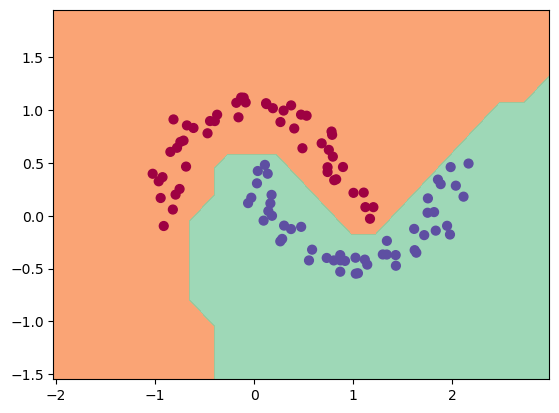

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


In [ ]:
x = Value(-4.0)
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y.backward()
xmg, ymg = x, y
print(xmg, ymg)
print(q.grad)

Value(data=-4.0, grad=46.0) Value(data=-20.0, grad=1)
-3.0
